In [69]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import mannwhitneyu
from scipy.stats import ttest_ind
from scipy.stats import f_oneway

%matplotlib inline

In [4]:
mu = 100
sigma = 10

In [5]:
population = np.round(np.random.normal(mu, sigma, 10000), 2)

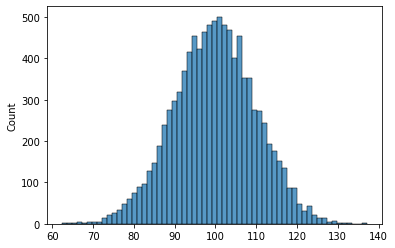

In [7]:
sns.histplot(population, kde=False)

In [31]:
mu = population.mean()

In [32]:
sigma = population.std()

In [51]:
sample_size = 5

In [52]:
se = sigma / sample_size ** 0.5

In [53]:
sample = np.random.choice(population, sample_size, False)

In [54]:
sample.mean()

101.24

Чем больше размер выборки, тем более точным получается среднее значение. Чем меньше размер, тем больше разброс

### z-распределение

In [55]:
z_scores = []
n = 10000

for i in range(n):
    sample = np.random.choice(population, sample_size, False)
    sample_mean = sample.mean()

    z_score = (sample_mean - mu) / se
    z_scores.append(z_score)

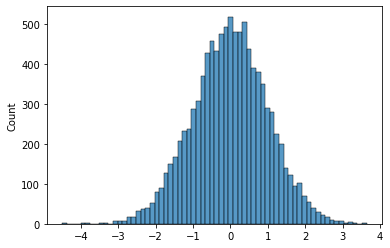

In [56]:
sns.histplot(z_scores, kde=False)

### t-распределение

In [57]:
n = 10000
t_scores = []

for i in range(n):
    sample = np.random.choice(population, sample_size, False)
    sample_mean = sample.mean()
    sample_std = sample.std()
    
    se_ = sample_std / sample_size ** 0.5

    t_score = (sample_mean - mu) / se_
    t_scores.append(t_score)

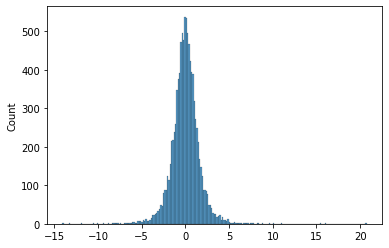

In [58]:
sns.histplot(t_scores, kde=False)

Распределение t-значений похоже на распределение z-значений, но с более высокими краями (экстремальные значения появляются чаще). Мы уходим от нормального распределения к t-распределению (распределение Стьюдента). На маленьких выборках разница разительная

У t-распределения есть степень свободы (у нормального – только среднее и стандартное отклонение). Чем больше степень свободы (больше выборка), тем более "опущены" хвосты. Чем меньше степень свободы, тем более "подняты" хвосты справа и слева.

Когда мы не знаем стандартное отклонение ГС и рассчитываем стандартную ошибку, поставив туда выборочное стандартное отклонение, мы теряем точность. И нам нужно повысить границу доверительного интервала, расширить его. Мы как бы добавили больше шума, и теперь нам нужен больший запас.

Но если выборка маленькая, то для t-значения история другая.

In [3]:
ads_data = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-da-chernova/shared/ads_data.csv.zip')

In [5]:
ads_data.head()

,ad_id,time,event,date,ad_cost_type,has_video,client_union_id,campaign_union_id,platform,ad_cost,target_audience_count,user_id
0,23456,1554076848,view,2019-04-01,CPM,0,5681,23456,android,190.0,125560,793
1,111941,1554135866,view,2019-04-01,CPM,0,111793,111941,ios,215.2,32277,1041
2,111941,1554135866,view,2019-04-01,CPM,0,111793,111941,ios,215.2,32277,41
3,42987,1554135866,view,2019-04-01,CPM,0,28541,42985,ios,199.1,80160,898
4,23456,1554135866,view,2019-04-01,CPM,0,5681,23456,web,190.0,125560,29


In [8]:
df = ads_data.groupby(['ad_id', 'ad_cost_type', 'platform', 'event'], as_index=False)\
                .agg({'user_id' : 'count'})

In [10]:
df.head()

,ad_id,ad_cost_type,platform,event,user_id
0,3,CPC,android,click,5
1,3,CPC,android,view,244
2,3,CPC,ios,click,3
3,3,CPC,ios,view,147
4,3,CPC,web,click,1


In [12]:
df = df.pivot(index=['ad_id', 'ad_cost_type', 'platform'],
columns='event', values='user_id').reset_index()

In [13]:
df.head()

event,ad_id,ad_cost_type,platform,click,view
0,3,CPC,android,5.0,244.0
1,3,CPC,ios,3.0,147.0
2,3,CPC,web,1.0,99.0
3,2132,CPC,android,1.0,55.0
4,2132,CPC,ios,NaN,26.0


**Сравнение двух и более групп**

In [81]:
platform_df = df.groupby(['ad_id', 'platform'], as_index=False) \
                .agg({'click' : 'sum', 'view':'sum'}).fillna(0)

In [83]:
platform_df = platform_df.query('view > 100 & click > 0')

In [84]:
platform_df = platform_df.assign(ctr = platform_df.click / platform_df.view)

In [87]:
platform_df = platform_df.assign(log_ctr = np.log(platform_df.ctr))

In [88]:
platform_df.head()

,ad_id,platform,click,view,ctr,log_ctr
0,3,android,5.0,244.0,0.020492,-3.887730
1,3,ios,3.0,147.0,0.020408,-3.891820
6,2276,android,2.0,703.0,0.002845,-5.862210
15,4585,android,17.0,224.0,0.075893,-2.578433
16,4585,ios,24.0,148.0,0.162162,-1.819158


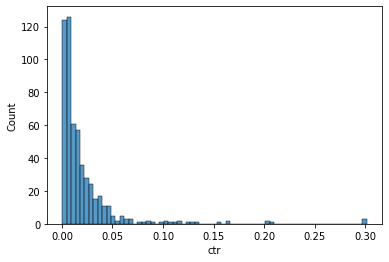

In [93]:
sns.histplot(data=platform_df.ctr)

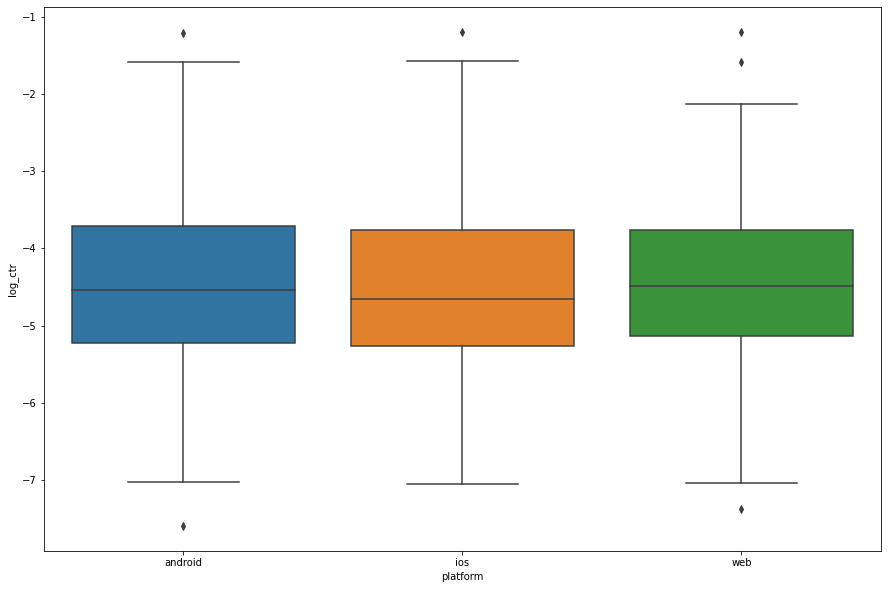

In [92]:
plt.figure(figsize=(15, 10))
sns.boxplot(data = platform_df, x='platform', y='log_ctr')

In [96]:
platform_df.groupby('platform', as_index=False).agg({'ctr' : 'median'})

,platform,ctr
0,android,0.010695
1,ios,0.009554
2,web,0.011213


In [ ]:
f_oneway(platform_df[platform_df.platform == 'web'].log_ctr,
         platform_df[platform_df.platform == 'android'].log_ctr,
         platform_df[platform_df.platform == 'ios']

**Как отличаются CTR в зависимости от типа оплаты?**  
(Сравнение двух групп)

In [17]:
cost_type_df = df.groupby(['ad_id', 'ad_cost_type'], as_index=False)\
                .agg({'click' : 'sum', 'view' : 'sum'})

In [21]:
cost_type_df.head()

,ad_id,ad_cost_type,click,view
0,3,CPC,9.0,490.0
1,2132,CPC,1.0,95.0
2,2276,CPC,2.0,1454.0
3,2475,CPM,0.0,132.0
4,2643,CPM,3.0,286.0


In [27]:
cost_type_df[['view']].median()

view    478.0
dtype: float64

In [57]:
cost_type_df = cost_type_df.query('view > 100 & click > 0')

In [58]:
cost_type_df = cost_type_df.assign(ctr = cost_type_df.click / cost_type_df.view)

In [70]:
cost_type_df['ctr_log'] = np.log(cost_type_df.ctr)

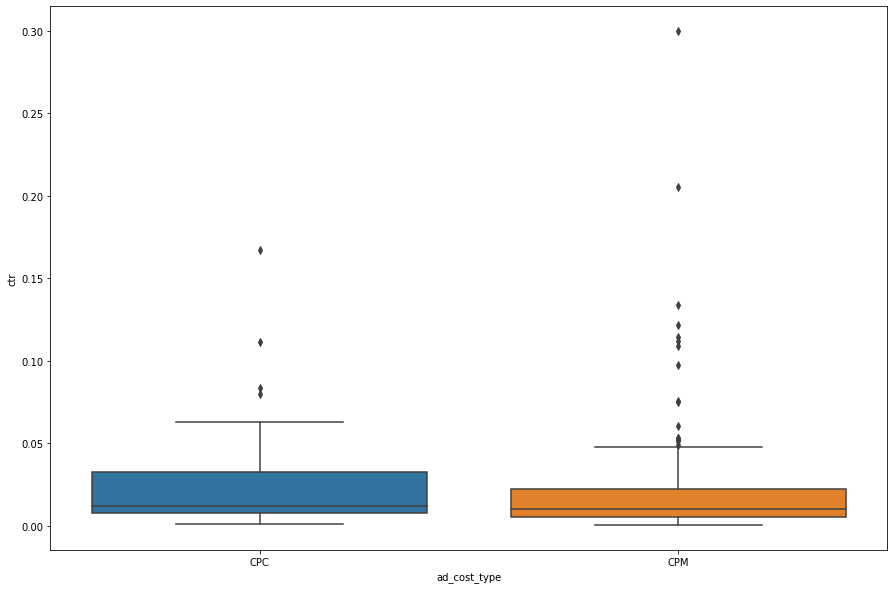

In [60]:
plt.figure(figsize=(15, 10))
sns.boxplot(data = cost_type_df, x='ad_cost_type', y='ctr')

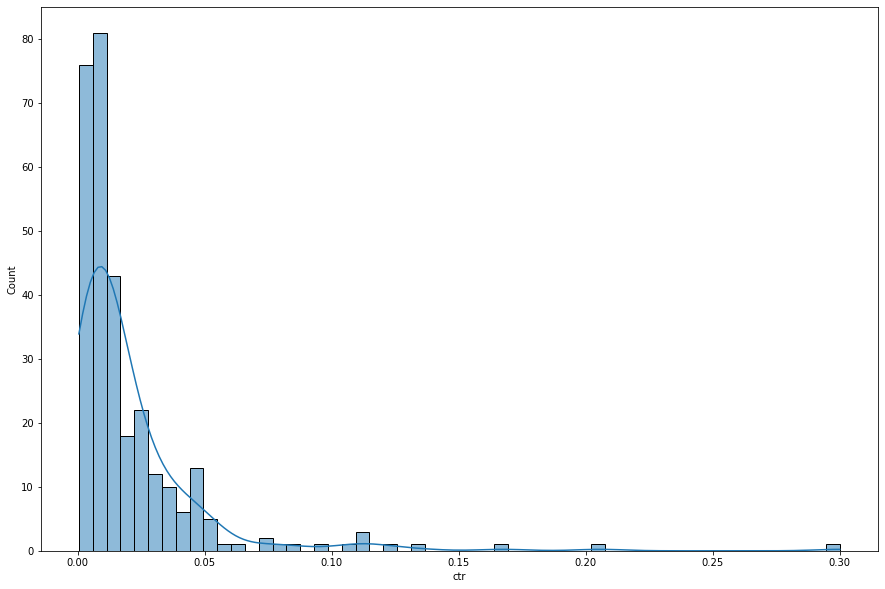

In [61]:
plt.figure(figsize=(15, 10))
sns.histplot(cost_type_df.ctr, kde=True)

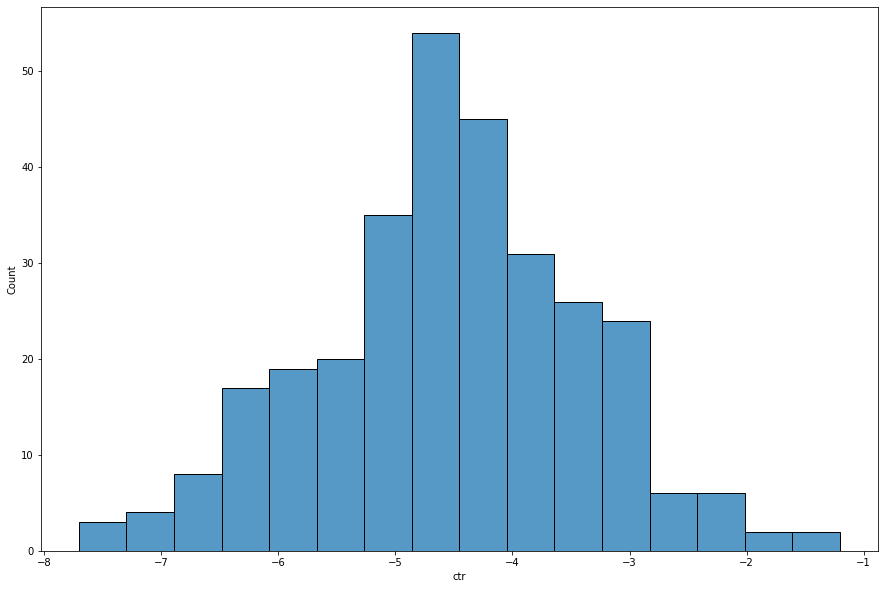

In [65]:
plt.figure(figsize=(15, 10))
sns.histplot(np.log(cost_type_df.ctr))

In [66]:
cost_type_df.groupby('ad_cost_type', as_index=False).agg({'ctr' : 'median'})

,ad_cost_type,ctr
0,CPC,0.012019
1,CPM,0.010490


In [67]:
cost_type_df.groupby('ad_cost_type', as_index=False).agg({'ctr' : 'mean'})

,ad_cost_type,ctr
0,CPC,0.024107
1,CPM,0.019467


In [71]:
cost_type_df.head()

,ad_id,ad_cost_type,click,view,ctr,ctr_log
0,3,CPC,9.0,490.0,0.018367,-3.997181
2,2276,CPC,2.0,1454.0,0.001376,-6.588926
4,2643,CPM,3.0,286.0,0.010490,-4.557380
5,4585,CPC,53.0,476.0,0.111345,-2.195126
6,4877,CPC,5.0,2160.0,0.002315,-6.068426


In [77]:
cost_type_df[cost_type_df.ad_cost_type == 'CPC'].ctr_log

0     -3.997181
2     -6.588926
5     -2.195126
6     -6.068426
7     -3.704823
11    -5.831882
13    -4.018549
14    -4.766438
15    -2.523226
17    -4.884694
19    -6.898715
20    -4.655863
21    -4.139159
25    -3.061386
31    -3.212187
32    -3.459466
34    -3.356746
37    -6.362597
52    -4.897840
54    -4.826712
82    -4.801285
106   -4.525405
117   -5.284218
120   -4.695011
125   -1.787876
151   -4.882802
155   -3.107436
228   -3.791737
245   -4.586242
254   -4.686952
255   -4.881286
256   -3.309630
258   -3.222790
259   -3.530553
266   -5.755215
270   -3.367296
279   -3.672496
284   -2.981276
295   -2.484907
300   -4.337291
301   -4.424847
304   -4.789573
306   -4.382027
321   -3.719651
322   -5.499215
332   -4.465908
333   -3.258097
334   -4.409763
335   -7.006695
336   -4.421247
337   -6.312944
340   -7.013016
348   -2.768245
351   -4.743191
354   -3.688379
Name: ctr_log, dtype: float64

In [78]:
ttest_ind(cost_type_df[cost_type_df.ad_cost_type == 'CPM'].ctr_log,
         cost_type_df[cost_type_df.ad_cost_type == 'CPC'].ctr_log)

Ttest_indResult(statistic=-1.1407296867039143, pvalue=0.25489224816951805)

In [79]:
ttest_ind(cost_type_df[cost_type_df.ad_cost_type == 'CPM'].ctr,
         cost_type_df[cost_type_df.ad_cost_type == 'CPC'].ctr)

Ttest_indResult(statistic=-1.0366111047153586, pvalue=0.3007519549674309)